# 1. Setting Up the Environment

In [22]:
# %%
# 1. Setting Up the Environment
import torch
import os
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pathlib import Path
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 2. Data Preparation

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prilia/fer2013pluscleanedaugmballanced1")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1


In [3]:
# access train and validation directory
train_dataset = r"C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\train"
test_dataset = r"C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\test"


print(f"Train Directory : {train_dataset}")
print(f"Validation Directory : {test_dataset}")


Train Directory : C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\train
Validation Directory : C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\test


## **3. Exploratory Data Analysis**

The general purpose of Exploratory Data Analysis (EDA) is to analyze data characteristics and find patterns, anomalies, and relationships between variables. In the EDA process, data cleaning is often carried out, such as handling missing values, removing duplicates, outliers, incorrect data, irrelevant data, imbalance data, and data transformation. This aims to obtain representative data so that the analysis results can provide useful insights for the business.

In Computer Vision tasks, EDA aims to ensure that the image dataset is truly clean, including in terms of data relevance, the annotations are complete, the format is the same, and the directory structure is appropriate so that the dataset is ready to be used for Machine Learning or Deep Learning modeling. Furthermore, EDA aims to find out the distribution of the dataset so that later it can be decided whether data augmentation is needed or not.

In this task, EDA is carried out to determine the dataset distribution, data format, and dataset samples. The dataset is considered clean because it has been prepared in a directory and is ready to be used for Computer Vision modeling.

In [4]:
total_class_train = len(os.listdir(train_dataset))
total_class_val = len(os.listdir(test_dataset))


print(f"Total of Train Data Classes: {train_dataset} classes")
print(f"Total of Validation Data Classes: {test_dataset} classes")


Total of Train Data Classes: C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\train classes
Total of Validation Data Classes: C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\test classes


In [5]:
# display data distribution
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

# calculate total data of each class
train_class_counts = count_data_per_class(train_dataset)
val_class_counts = count_data_per_class(test_dataset)

# create dataframe class count
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [6]:
train_counts_df

,Count
Anger,3315
Disgust,3367
Fear,3346
Happy,3334
Neutral,3376
Sad,3192
Surprise,3321


In [7]:
val_counts_df

,Count
Anger,828
Disgust,841
Fear,836
Happy,833
Neutral,806
Sad,798
Surprise,830


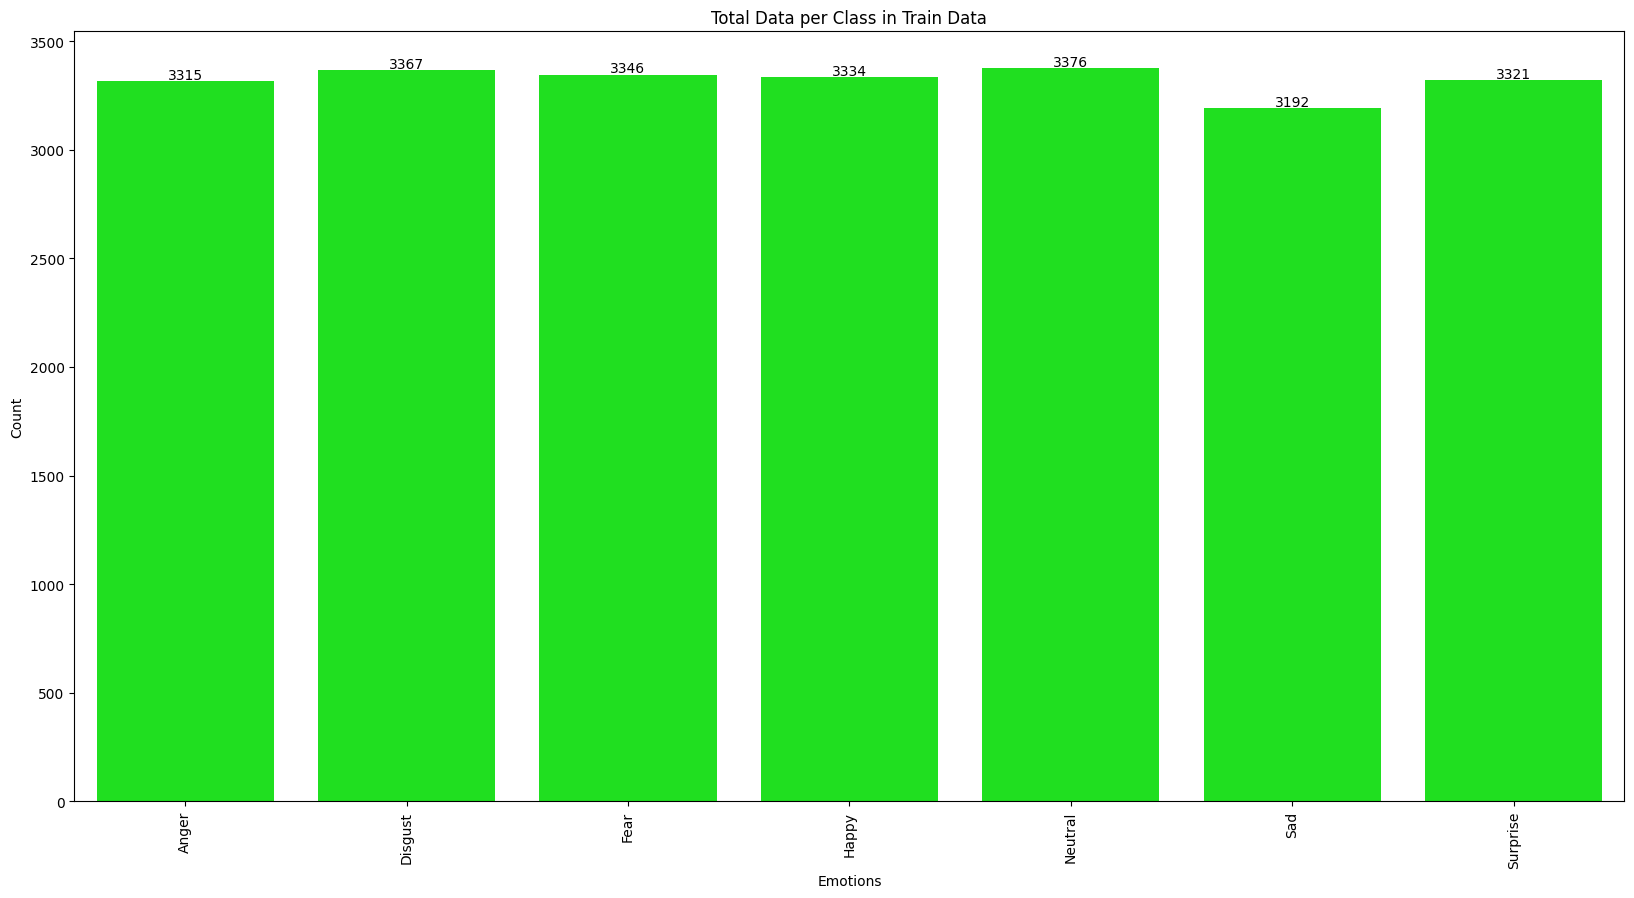

In [8]:
# display barplot for train data
plt.figure(figsize=(20, 10))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="lime")
plt.title("Total Data per Class in Train Data")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.xticks(rotation=90)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+10, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

# saving plot
plt.savefig("Total Data per Class in Train Data.jpg")

# show the plot
plt.show()

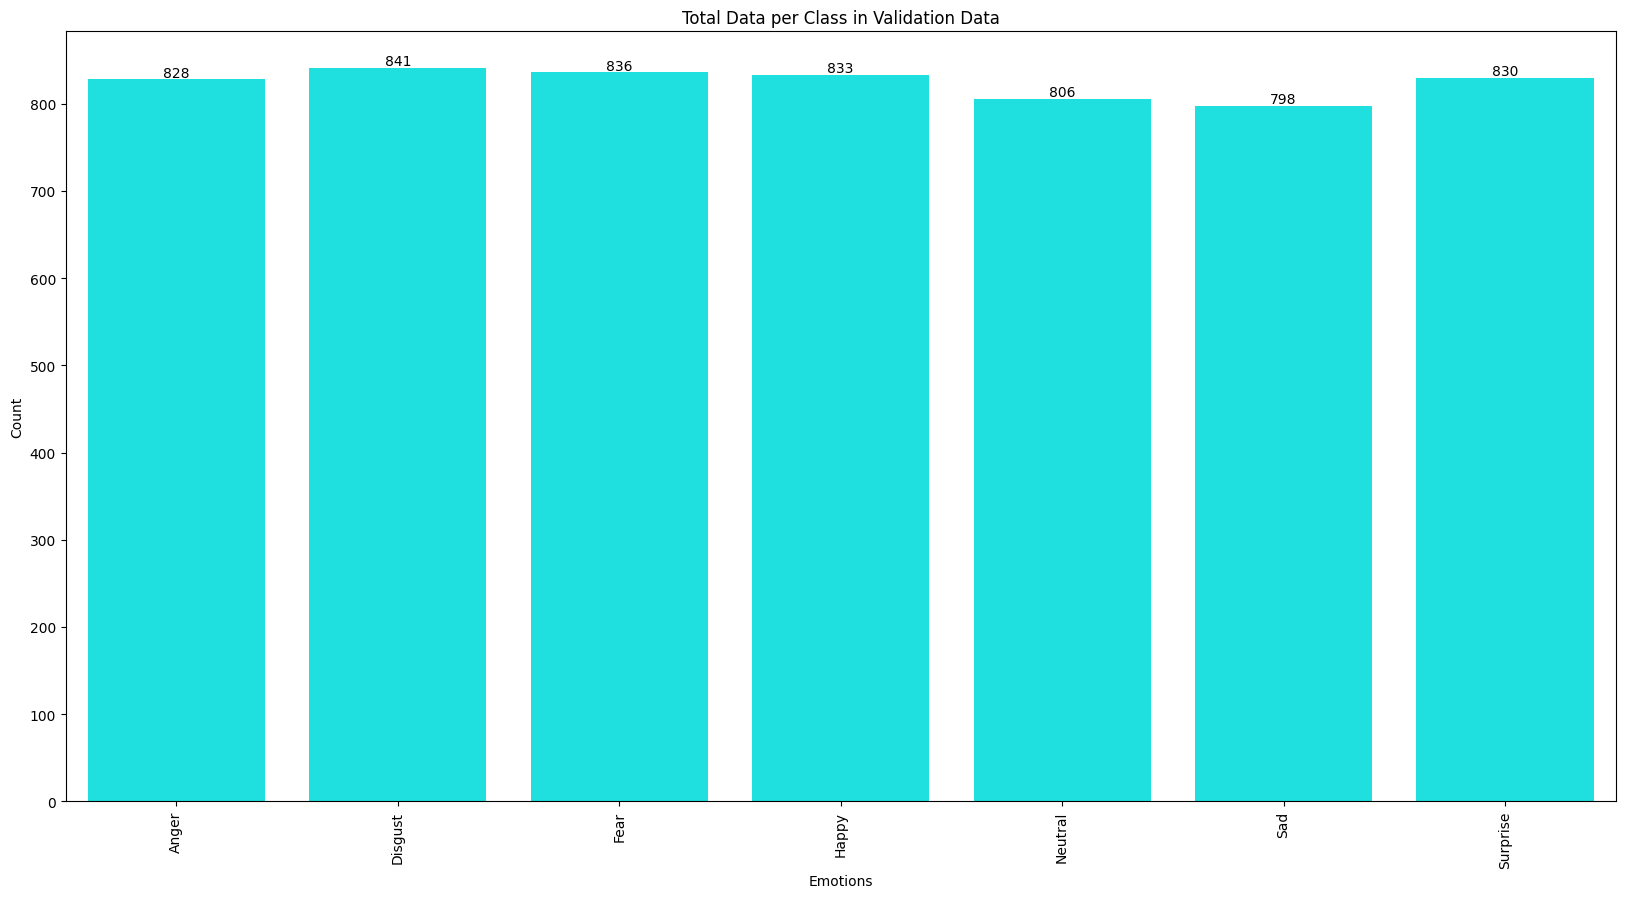

In [9]:
# display barplot for validation data
plt.figure(figsize=(20, 10))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="cyan")
plt.title("Total Data per Class in Validation Data")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.xticks(rotation=90)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+3, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

# saving plot
plt.savefig("Total Data per Class in Validation Data.jpg")

# show the plot
plt.show()

In [10]:
# total image for training and validation

print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")

Total Image for Training: 23251 images
Total Image for Validation: 5772 images


# 4. Model Training

In [67]:

# Load FER dataset from image folders
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images to 48x48 (FER standard size)
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset from folders
train_dataset = datasets.ImageFolder(root=r'C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\train', transform=transform)
test_dataset = datasets.ImageFolder(root=r'C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\test', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names
print('Classes:', train_dataset.classes)


Classes: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [17]:

# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss, train accuracy, precision, recall, and f1-score
    train_loss, train_acc = 0, 0
    all_preds, all_labels = [], []

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Store predictions and labels for precision, recall, and F1-score
        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    # Calculate precision, recall, and F1-score
    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return train_loss, train_acc, train_precision, train_recall, train_f1


In [18]:


# validation loop function
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup validation loss, accuracy, precision, recall, and f1-score
    val_loss, val_acc = 0, 0
    all_preds, all_labels = [], []

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)

            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

            # Store predictions and labels for precision, recall, and F1-score
            all_preds.extend(val_pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    # Calculate precision, recall, and F1-score
    val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return val_loss, val_acc, val_precision, val_recall, val_f1


In [19]:
from tqdm import tqdm

# train process
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": []
    }

    # loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )

        val_loss, val_acc, val_precision, val_recall, val_f1 = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn
        )

        # print out training progress
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
            f"train_precision: {train_precision:.4f} | train_recall: {train_recall:.4f} | train_f1: {train_f1:.4f} | "
            f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | "
            f"val_precision: {val_precision:.4f} | val_recall: {val_recall:.4f} | val_f1: {val_f1:.4f}"
        )

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)

        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_precision"].append(val_precision)
        results["val_recall"].append(val_recall)
        results["val_f1"].append(val_f1)

    # return the filled results at the end of the epochs
    return results


## **5. Training Process**

### 5.1. Training ResNet50 Model

In [68]:

# Define multiple CNN models (ResNet50, EfficientNetV2-S, MobileNetV3-Small) for FER classification
import torch
import torch.nn as nn
import torchvision.models as models

# Function to get the desired model
def get_model(model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)

    elif model_name == 'efficientnet':
        model = models.efficientnet_v2_s(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 7)

    elif model_name == 'mobilenet':
        model = models.mobilenet_v3_small(pretrained=True)
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, 7)

    else:
        raise ValueError("Invalid model name. Choose from 'resnet50', 'efficientnet', or 'mobilenet'.")

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    return model

# Choose the model (Change this to 'efficientnet' or 'mobilenet' to switch)
model_name = 'resnet50'  # Change to 'efficientnet' or 'mobilenet' as needed
model = get_model(model_name)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Using {model_name} for training.")


c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using resnet50 for training.


In [21]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
# set number of epochs
NUM_EPOCHS = 20

# start the timer
start_time = time.time()

# train fine tuning ResNet50 model
rn50_results = train_process(model=model,
                             train_dataloader=train_loader,
                             val_dataloader=test_loader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
time_taken = time.time() - start_time
print(f"Time taken for training: {time_taken} seconds")

  5%|▌         | 1/20 [02:13<42:18, 133.59s/it]

Epoch: 1 | train_loss: 1.1188 | train_acc: 0.5865 | train_precision: 0.5876 | train_recall: 0.5864 | train_f1: 0.5860 | val_loss: 1.1325 | val_acc: 0.6515 | val_precision: 0.6824 | val_recall: 0.6506 | val_f1: 0.6466


 10%|█         | 2/20 [03:58<34:56, 116.47s/it]

Epoch: 2 | train_loss: 0.8574 | train_acc: 0.6854 | train_precision: 0.6877 | train_recall: 0.6855 | train_f1: 0.6862 | val_loss: 0.8081 | val_acc: 0.7055 | val_precision: 0.7006 | val_recall: 0.7048 | val_f1: 0.7001


 15%|█▌        | 3/20 [05:39<31:06, 109.80s/it]

Epoch: 3 | train_loss: 0.7156 | train_acc: 0.7390 | train_precision: 0.7405 | train_recall: 0.7390 | train_f1: 0.7396 | val_loss: 0.7353 | val_acc: 0.7299 | val_precision: 0.7277 | val_recall: 0.7296 | val_f1: 0.7222


 20%|██        | 4/20 [07:43<30:43, 115.21s/it]

Epoch: 4 | train_loss: 0.6044 | train_acc: 0.7779 | train_precision: 0.7794 | train_recall: 0.7779 | train_f1: 0.7785 | val_loss: 0.7600 | val_acc: 0.7354 | val_precision: 0.7421 | val_recall: 0.7351 | val_f1: 0.7325


 25%|██▌       | 5/20 [09:31<28:10, 112.71s/it]

Epoch: 5 | train_loss: 0.5217 | train_acc: 0.8076 | train_precision: 0.8088 | train_recall: 0.8077 | train_f1: 0.8081 | val_loss: 0.7492 | val_acc: 0.7319 | val_precision: 0.7361 | val_recall: 0.7318 | val_f1: 0.7295


 30%|███       | 6/20 [11:19<25:54, 111.03s/it]

Epoch: 6 | train_loss: 0.4463 | train_acc: 0.8366 | train_precision: 0.8375 | train_recall: 0.8366 | train_f1: 0.8369 | val_loss: 0.7684 | val_acc: 0.7372 | val_precision: 0.7516 | val_recall: 0.7372 | val_f1: 0.7367


 35%|███▌      | 7/20 [13:19<24:39, 113.82s/it]

Epoch: 7 | train_loss: 0.3697 | train_acc: 0.8646 | train_precision: 0.8650 | train_recall: 0.8646 | train_f1: 0.8648 | val_loss: 0.7691 | val_acc: 0.7416 | val_precision: 0.7467 | val_recall: 0.7410 | val_f1: 0.7359


 40%|████      | 8/20 [15:34<24:07, 120.63s/it]

Epoch: 8 | train_loss: 0.3072 | train_acc: 0.8887 | train_precision: 0.8891 | train_recall: 0.8888 | train_f1: 0.8889 | val_loss: 0.7464 | val_acc: 0.7639 | val_precision: 0.7616 | val_recall: 0.7637 | val_f1: 0.7617


 45%|████▌     | 9/20 [17:54<23:15, 126.90s/it]

Epoch: 9 | train_loss: 0.2568 | train_acc: 0.9074 | train_precision: 0.9076 | train_recall: 0.9075 | train_f1: 0.9075 | val_loss: 0.8256 | val_acc: 0.7537 | val_precision: 0.7575 | val_recall: 0.7535 | val_f1: 0.7540


 50%|█████     | 10/20 [20:39<23:06, 138.65s/it]

Epoch: 10 | train_loss: 0.2095 | train_acc: 0.9266 | train_precision: 0.9266 | train_recall: 0.9265 | train_f1: 0.9266 | val_loss: 0.8407 | val_acc: 0.7590 | val_precision: 0.7703 | val_recall: 0.7585 | val_f1: 0.7609


 55%|█████▌    | 11/20 [23:21<21:52, 145.79s/it]

Epoch: 11 | train_loss: 0.1776 | train_acc: 0.9366 | train_precision: 0.9367 | train_recall: 0.9366 | train_f1: 0.9366 | val_loss: 0.8898 | val_acc: 0.7514 | val_precision: 0.7592 | val_recall: 0.7517 | val_f1: 0.7509


 60%|██████    | 12/20 [31:13<32:38, 244.85s/it]

Epoch: 12 | train_loss: 0.1558 | train_acc: 0.9461 | train_precision: 0.9461 | train_recall: 0.9461 | train_f1: 0.9461 | val_loss: 0.9337 | val_acc: 0.7540 | val_precision: 0.7579 | val_recall: 0.7540 | val_f1: 0.7526


 65%|██████▌   | 13/20 [36:47<31:44, 272.05s/it]

Epoch: 13 | train_loss: 0.1432 | train_acc: 0.9503 | train_precision: 0.9504 | train_recall: 0.9503 | train_f1: 0.9503 | val_loss: 0.9011 | val_acc: 0.7653 | val_precision: 0.7727 | val_recall: 0.7651 | val_f1: 0.7667


 70%|███████   | 14/20 [38:15<21:38, 216.41s/it]

Epoch: 14 | train_loss: 0.1303 | train_acc: 0.9531 | train_precision: 0.9532 | train_recall: 0.9531 | train_f1: 0.9531 | val_loss: 1.0279 | val_acc: 0.7570 | val_precision: 0.7677 | val_recall: 0.7568 | val_f1: 0.7588


 75%|███████▌  | 15/20 [39:39<14:41, 176.26s/it]

Epoch: 15 | train_loss: 0.1086 | train_acc: 0.9618 | train_precision: 0.9618 | train_recall: 0.9619 | train_f1: 0.9618 | val_loss: 1.0667 | val_acc: 0.7605 | val_precision: 0.7733 | val_recall: 0.7606 | val_f1: 0.7622


 80%|████████  | 16/20 [40:57<09:46, 146.73s/it]

Epoch: 16 | train_loss: 0.1075 | train_acc: 0.9633 | train_precision: 0.9633 | train_recall: 0.9633 | train_f1: 0.9633 | val_loss: 1.0494 | val_acc: 0.7654 | val_precision: 0.7734 | val_recall: 0.7654 | val_f1: 0.7671


 85%|████████▌ | 17/20 [42:16<06:19, 126.45s/it]

Epoch: 17 | train_loss: 0.1160 | train_acc: 0.9617 | train_precision: 0.9617 | train_recall: 0.9617 | train_f1: 0.9617 | val_loss: 0.9822 | val_acc: 0.7647 | val_precision: 0.7705 | val_recall: 0.7647 | val_f1: 0.7658


 90%|█████████ | 18/20 [43:33<03:43, 111.75s/it]

Epoch: 18 | train_loss: 0.0871 | train_acc: 0.9701 | train_precision: 0.9701 | train_recall: 0.9701 | train_f1: 0.9701 | val_loss: 1.0577 | val_acc: 0.7776 | val_precision: 0.7854 | val_recall: 0.7777 | val_f1: 0.7798


 95%|█████████▌| 19/20 [44:53<01:42, 102.02s/it]

Epoch: 19 | train_loss: 0.0836 | train_acc: 0.9717 | train_precision: 0.9717 | train_recall: 0.9717 | train_f1: 0.9717 | val_loss: 1.0995 | val_acc: 0.7713 | val_precision: 0.7823 | val_recall: 0.7708 | val_f1: 0.7725


100%|██████████| 20/20 [46:11<00:00, 138.60s/it]

Epoch: 20 | train_loss: 0.0841 | train_acc: 0.9711 | train_precision: 0.9711 | train_recall: 0.9711 | train_f1: 0.9711 | val_loss: 1.0600 | val_acc: 0.7670 | val_precision: 0.7726 | val_recall: 0.7668 | val_f1: 0.7682
Time taken for training: 2771.9287264347076 seconds


In [23]:
# 1. create models directory
model_path = Path(r"C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "Emotion_detection_resnet.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion\Emotion_detection_resnet.pth


In [24]:

# Define multiple CNN models (ResNet50, EfficientNetV2-S, MobileNetV3-Small) for FER classification
import torch
import torch.nn as nn
import torchvision.models as models

# Function to get the desired model
def get_model(model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)

    elif model_name == 'efficientnet':
        model = models.efficientnet_v2_s(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 7)

    elif model_name == 'mobilenet':
        model = models.mobilenet_v3_small(pretrained=True)
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, 7)

    else:
        raise ValueError("Invalid model name. Choose from 'resnet50', 'efficientnet', or 'mobilenet'.")

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    return model

# Choose the model (Change this to 'efficientnet' or 'mobilenet' to switch)
model_name = 'efficientnet'  # Change to 'efficientnet' or 'mobilenet' as needed
model = get_model(model_name)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Using {model_name} for training.")


c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using efficientnet for training.


### 5.2. Training EfficientNet V2 Model

In [25]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
# set number of epochs
NUM_EPOCHS = 20

# start the timer
start_time = time.time()

# train fine tuning Efficient model
ev2_results = train_process(model=model,
                             train_dataloader=train_loader,
                             val_dataloader=test_loader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
time_taken = time.time() - start_time
print(f"Time taken for training: {time_taken} seconds")

  5%|▌         | 1/20 [02:20<44:28, 140.46s/it]

Epoch: 1 | train_loss: 0.9977 | train_acc: 0.6347 | train_precision: 0.6354 | train_recall: 0.6347 | train_f1: 0.6345 | val_loss: 0.7585 | val_acc: 0.7333 | val_precision: 0.7619 | val_recall: 0.7327 | val_f1: 0.7306


 10%|█         | 2/20 [04:39<41:48, 139.38s/it]

Epoch: 2 | train_loss: 0.6486 | train_acc: 0.7693 | train_precision: 0.7710 | train_recall: 0.7693 | train_f1: 0.7699 | val_loss: 0.6220 | val_acc: 0.7775 | val_precision: 0.7769 | val_recall: 0.7770 | val_f1: 0.7749


 15%|█▌        | 3/20 [06:54<38:55, 137.37s/it]

Epoch: 3 | train_loss: 0.5182 | train_acc: 0.8167 | train_precision: 0.8180 | train_recall: 0.8168 | train_f1: 0.8173 | val_loss: 0.6118 | val_acc: 0.7883 | val_precision: 0.8022 | val_recall: 0.7881 | val_f1: 0.7900


 20%|██        | 4/20 [09:07<36:12, 135.81s/it]

Epoch: 4 | train_loss: 0.4061 | train_acc: 0.8547 | train_precision: 0.8553 | train_recall: 0.8547 | train_f1: 0.8550 | val_loss: 0.6496 | val_acc: 0.7882 | val_precision: 0.7877 | val_recall: 0.7878 | val_f1: 0.7855


 25%|██▌       | 5/20 [11:22<33:51, 135.47s/it]

Epoch: 5 | train_loss: 0.3332 | train_acc: 0.8832 | train_precision: 0.8835 | train_recall: 0.8832 | train_f1: 0.8833 | val_loss: 0.6142 | val_acc: 0.7952 | val_precision: 0.7993 | val_recall: 0.7950 | val_f1: 0.7956


 30%|███       | 6/20 [13:37<31:36, 135.44s/it]

Epoch: 6 | train_loss: 0.2638 | train_acc: 0.9078 | train_precision: 0.9079 | train_recall: 0.9077 | train_f1: 0.9078 | val_loss: 0.7541 | val_acc: 0.7802 | val_precision: 0.7785 | val_recall: 0.7800 | val_f1: 0.7753


 35%|███▌      | 7/20 [15:50<29:10, 134.63s/it]

Epoch: 7 | train_loss: 0.2206 | train_acc: 0.9245 | train_precision: 0.9247 | train_recall: 0.9246 | train_f1: 0.9246 | val_loss: 0.7448 | val_acc: 0.7874 | val_precision: 0.7957 | val_recall: 0.7872 | val_f1: 0.7894


 40%|████      | 8/20 [18:06<26:58, 134.89s/it]

Epoch: 8 | train_loss: 0.1930 | train_acc: 0.9341 | train_precision: 0.9342 | train_recall: 0.9341 | train_f1: 0.9342 | val_loss: 0.7482 | val_acc: 0.7808 | val_precision: 0.7885 | val_recall: 0.7807 | val_f1: 0.7810


 45%|████▌     | 9/20 [20:21<24:45, 135.03s/it]

Epoch: 9 | train_loss: 0.1586 | train_acc: 0.9464 | train_precision: 0.9465 | train_recall: 0.9465 | train_f1: 0.9465 | val_loss: 0.7980 | val_acc: 0.7769 | val_precision: 0.7799 | val_recall: 0.7767 | val_f1: 0.7747


 50%|█████     | 10/20 [24:13<27:31, 165.13s/it]

Epoch: 10 | train_loss: 0.1393 | train_acc: 0.9542 | train_precision: 0.9542 | train_recall: 0.9542 | train_f1: 0.9542 | val_loss: 0.7639 | val_acc: 0.7971 | val_precision: 0.7995 | val_recall: 0.7973 | val_f1: 0.7976


 55%|█████▌    | 11/20 [28:36<29:14, 194.96s/it]

Epoch: 11 | train_loss: 0.1280 | train_acc: 0.9567 | train_precision: 0.9567 | train_recall: 0.9567 | train_f1: 0.9567 | val_loss: 0.8307 | val_acc: 0.8000 | val_precision: 0.8078 | val_recall: 0.7999 | val_f1: 0.8019


 60%|██████    | 12/20 [33:07<29:03, 217.93s/it]

Epoch: 12 | train_loss: 0.1107 | train_acc: 0.9632 | train_precision: 0.9632 | train_recall: 0.9632 | train_f1: 0.9632 | val_loss: 0.8070 | val_acc: 0.7882 | val_precision: 0.7896 | val_recall: 0.7883 | val_f1: 0.7874


 65%|██████▌   | 13/20 [35:53<23:36, 202.35s/it]

Epoch: 13 | train_loss: 0.1273 | train_acc: 0.9573 | train_precision: 0.9574 | train_recall: 0.9573 | train_f1: 0.9573 | val_loss: 0.8749 | val_acc: 0.7821 | val_precision: 0.7877 | val_recall: 0.7819 | val_f1: 0.7823


 70%|███████   | 14/20 [37:19<16:42, 167.10s/it]

Epoch: 14 | train_loss: 0.0926 | train_acc: 0.9689 | train_precision: 0.9689 | train_recall: 0.9689 | train_f1: 0.9689 | val_loss: 0.8009 | val_acc: 0.7917 | val_precision: 0.7959 | val_recall: 0.7912 | val_f1: 0.7928


 75%|███████▌  | 15/20 [38:48<11:57, 143.56s/it]

Epoch: 15 | train_loss: 0.0854 | train_acc: 0.9734 | train_precision: 0.9734 | train_recall: 0.9734 | train_f1: 0.9734 | val_loss: 0.8786 | val_acc: 0.7926 | val_precision: 0.8034 | val_recall: 0.7924 | val_f1: 0.7938


 80%|████████  | 16/20 [41:45<10:14, 153.71s/it]

Epoch: 16 | train_loss: 0.0854 | train_acc: 0.9720 | train_precision: 0.9721 | train_recall: 0.9720 | train_f1: 0.9720 | val_loss: 0.9261 | val_acc: 0.7859 | val_precision: 0.7963 | val_recall: 0.7857 | val_f1: 0.7877


 85%|████████▌ | 17/20 [45:30<08:45, 175.16s/it]

Epoch: 17 | train_loss: 0.0838 | train_acc: 0.9723 | train_precision: 0.9723 | train_recall: 0.9723 | train_f1: 0.9723 | val_loss: 0.8367 | val_acc: 0.7908 | val_precision: 0.8020 | val_recall: 0.7912 | val_f1: 0.7939


 90%|█████████ | 18/20 [47:58<05:33, 166.98s/it]

Epoch: 18 | train_loss: 0.0721 | train_acc: 0.9763 | train_precision: 0.9763 | train_recall: 0.9763 | train_f1: 0.9763 | val_loss: 0.9424 | val_acc: 0.7756 | val_precision: 0.7843 | val_recall: 0.7751 | val_f1: 0.7781


 95%|█████████▌| 19/20 [50:25<02:40, 160.98s/it]

Epoch: 19 | train_loss: 0.0701 | train_acc: 0.9781 | train_precision: 0.9781 | train_recall: 0.9781 | train_f1: 0.9781 | val_loss: 0.8941 | val_acc: 0.7851 | val_precision: 0.7857 | val_recall: 0.7847 | val_f1: 0.7840


100%|██████████| 20/20 [53:04<00:00, 159.24s/it]

Epoch: 20 | train_loss: 0.0681 | train_acc: 0.9780 | train_precision: 0.9780 | train_recall: 0.9780 | train_f1: 0.9780 | val_loss: 0.9586 | val_acc: 0.7913 | val_precision: 0.7957 | val_recall: 0.7914 | val_f1: 0.7924
Time taken for training: 3184.713220357895 seconds


In [26]:
# 1. create models directory
model_path = Path(r"C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "Emotion_detection_Efficient.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion\Emotion_detection_Efficient.pth


In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models

# Function to get the desired model
def get_model(model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)

    elif model_name == 'efficientnet':
        model = models.efficientnet_v2_s(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 7)

    elif model_name == 'mobilenet':
        model = models.mobilenet_v3_small(pretrained=True)
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, 7)

    else:
        raise ValueError("Invalid model name. Choose from 'resnet50', 'efficientnet', or 'mobilenet'.")

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    return model

# Choose the model (Change this to 'efficientnet' or 'mobilenet' to switch)
model_name = 'mobilenet'  # Change to 'efficientnet' or 'mobilenet' as needed
model = get_model(model_name)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Using {model_name} for training.")


Using mobilenet for training.


c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 5.3. Training MobileNet V2 Model

In [28]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
# set number of epochs
NUM_EPOCHS = 20

# start the timer
start_time = time.time()

# train fine tuning ResNet50 model
mobilenet_results = train_process(model=model,
                             train_dataloader=train_loader,
                             val_dataloader=test_loader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
time_taken = time.time() - start_time
print(f"Time taken for training: {time_taken} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [01:13<23:16, 73.50s/it]

Epoch: 1 | train_loss: 1.3084 | train_acc: 0.5007 | train_precision: 0.4988 | train_recall: 0.5007 | train_f1: 0.4988 | val_loss: 1.1704 | val_acc: 0.5718 | val_precision: 0.5853 | val_recall: 0.5709 | val_f1: 0.5640


 10%|█         | 2/20 [02:12<19:24, 64.69s/it]

Epoch: 2 | train_loss: 1.0095 | train_acc: 0.6220 | train_precision: 0.6229 | train_recall: 0.6220 | train_f1: 0.6217 | val_loss: 1.0000 | val_acc: 0.6347 | val_precision: 0.6561 | val_recall: 0.6343 | val_f1: 0.6391


 15%|█▌        | 3/20 [03:10<17:28, 61.68s/it]

Epoch: 3 | train_loss: 0.8873 | train_acc: 0.6674 | train_precision: 0.6687 | train_recall: 0.6674 | train_f1: 0.6677 | val_loss: 0.9688 | val_acc: 0.6431 | val_precision: 0.6532 | val_recall: 0.6424 | val_f1: 0.6400


 20%|██        | 4/20 [04:08<16:04, 60.30s/it]

Epoch: 4 | train_loss: 0.7853 | train_acc: 0.7083 | train_precision: 0.7106 | train_recall: 0.7082 | train_f1: 0.7091 | val_loss: 0.9854 | val_acc: 0.6423 | val_precision: 0.6695 | val_recall: 0.6414 | val_f1: 0.6389


 25%|██▌       | 5/20 [05:06<14:52, 59.47s/it]

Epoch: 5 | train_loss: 0.7075 | train_acc: 0.7395 | train_precision: 0.7416 | train_recall: 0.7395 | train_f1: 0.7402 | val_loss: 1.0227 | val_acc: 0.6515 | val_precision: 0.6587 | val_recall: 0.6509 | val_f1: 0.6393


 30%|███       | 6/20 [06:04<13:46, 59.03s/it]

Epoch: 6 | train_loss: 0.6365 | train_acc: 0.7642 | train_precision: 0.7669 | train_recall: 0.7642 | train_f1: 0.7652 | val_loss: 0.9335 | val_acc: 0.6932 | val_precision: 0.7042 | val_recall: 0.6930 | val_f1: 0.6899


 35%|███▌      | 7/20 [07:22<14:07, 65.19s/it]

Epoch: 7 | train_loss: 0.5735 | train_acc: 0.7870 | train_precision: 0.7888 | train_recall: 0.7871 | train_f1: 0.7877 | val_loss: 0.9635 | val_acc: 0.6850 | val_precision: 0.6887 | val_recall: 0.6845 | val_f1: 0.6751


 40%|████      | 8/20 [08:20<12:34, 62.84s/it]

Epoch: 8 | train_loss: 0.5147 | train_acc: 0.8096 | train_precision: 0.8106 | train_recall: 0.8096 | train_f1: 0.8100 | val_loss: 0.9332 | val_acc: 0.7002 | val_precision: 0.7077 | val_recall: 0.6994 | val_f1: 0.6983


 45%|████▌     | 9/20 [09:18<11:15, 61.39s/it]

Epoch: 9 | train_loss: 0.4540 | train_acc: 0.8332 | train_precision: 0.8342 | train_recall: 0.8332 | train_f1: 0.8336 | val_loss: 0.9381 | val_acc: 0.7036 | val_precision: 0.7151 | val_recall: 0.7029 | val_f1: 0.7069


 50%|█████     | 10/20 [10:16<10:03, 60.38s/it]

Epoch: 10 | train_loss: 0.4079 | train_acc: 0.8514 | train_precision: 0.8522 | train_recall: 0.8514 | train_f1: 0.8517 | val_loss: 1.0727 | val_acc: 0.6949 | val_precision: 0.7048 | val_recall: 0.6944 | val_f1: 0.6968


 55%|█████▌    | 11/20 [11:36<09:57, 66.44s/it]

Epoch: 11 | train_loss: 0.3656 | train_acc: 0.8654 | train_precision: 0.8660 | train_recall: 0.8653 | train_f1: 0.8656 | val_loss: 1.0269 | val_acc: 0.7013 | val_precision: 0.7119 | val_recall: 0.7008 | val_f1: 0.7013


 60%|██████    | 12/20 [12:51<09:11, 68.96s/it]

Epoch: 12 | train_loss: 0.3191 | train_acc: 0.8827 | train_precision: 0.8832 | train_recall: 0.8828 | train_f1: 0.8829 | val_loss: 1.1727 | val_acc: 0.6881 | val_precision: 0.6972 | val_recall: 0.6876 | val_f1: 0.6881


 65%|██████▌   | 13/20 [13:50<07:41, 65.96s/it]

Epoch: 13 | train_loss: 0.2924 | train_acc: 0.8950 | train_precision: 0.8955 | train_recall: 0.8951 | train_f1: 0.8952 | val_loss: 1.1168 | val_acc: 0.6998 | val_precision: 0.7032 | val_recall: 0.6991 | val_f1: 0.7005


 70%|███████   | 14/20 [14:48<06:21, 63.56s/it]

Epoch: 14 | train_loss: 0.2706 | train_acc: 0.9055 | train_precision: 0.9058 | train_recall: 0.9056 | train_f1: 0.9057 | val_loss: 1.1684 | val_acc: 0.7010 | val_precision: 0.7054 | val_recall: 0.7003 | val_f1: 0.7015


 75%|███████▌  | 15/20 [16:08<05:42, 68.53s/it]

Epoch: 15 | train_loss: 0.2444 | train_acc: 0.9157 | train_precision: 0.9159 | train_recall: 0.9157 | train_f1: 0.9158 | val_loss: 1.2151 | val_acc: 0.7078 | val_precision: 0.7121 | val_recall: 0.7070 | val_f1: 0.7083


 80%|████████  | 16/20 [18:06<05:34, 83.51s/it]

Epoch: 16 | train_loss: 0.2327 | train_acc: 0.9158 | train_precision: 0.9161 | train_recall: 0.9158 | train_f1: 0.9159 | val_loss: 1.2131 | val_acc: 0.7113 | val_precision: 0.7137 | val_recall: 0.7108 | val_f1: 0.7111


 85%|████████▌ | 17/20 [19:00<03:43, 74.41s/it]

Epoch: 17 | train_loss: 0.2084 | train_acc: 0.9244 | train_precision: 0.9245 | train_recall: 0.9244 | train_f1: 0.9245 | val_loss: 1.3339 | val_acc: 0.7002 | val_precision: 0.7049 | val_recall: 0.6994 | val_f1: 0.7002


 90%|█████████ | 18/20 [19:58<02:19, 69.63s/it]

Epoch: 18 | train_loss: 0.1996 | train_acc: 0.9297 | train_precision: 0.9298 | train_recall: 0.9297 | train_f1: 0.9297 | val_loss: 1.2857 | val_acc: 0.7062 | val_precision: 0.7104 | val_recall: 0.7055 | val_f1: 0.7074


 95%|█████████▌| 19/20 [20:56<01:06, 66.17s/it]

Epoch: 19 | train_loss: 0.1943 | train_acc: 0.9326 | train_precision: 0.9326 | train_recall: 0.9326 | train_f1: 0.9326 | val_loss: 1.4304 | val_acc: 0.7093 | val_precision: 0.7083 | val_recall: 0.7086 | val_f1: 0.7061


100%|██████████| 20/20 [21:55<00:00, 65.75s/it]

Epoch: 20 | train_loss: 0.1800 | train_acc: 0.9375 | train_precision: 0.9376 | train_recall: 0.9376 | train_f1: 0.9376 | val_loss: 1.4073 | val_acc: 0.7033 | val_precision: 0.7139 | val_recall: 0.7029 | val_f1: 0.7058
Time taken for training: 1315.078771352768 seconds


In [29]:
# 1. create models directory
model_path = Path(r"C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "Emotion_detection_Mobilenet.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion\Emotion_detection_Mobilenet.pth


In [53]:
# Load FER dataset from image folders
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for FER dataset (Grayscale)
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize to match model input
    transforms.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Load dataset from folders
train_dataset = datasets.ImageFolder(
    root=r'C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\train',
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=r'C:\Users\peer1\.cache\kagglehub\datasets\prilia\fer2013pluscleanedaugmballanced1\versions\1\test',
    transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names
print('Classes:', train_dataset.classes)


Classes: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


# Training Custom Model

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CustomCNN Model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # 1st Convolution Layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.25)

        # 2nd Convolution Layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.25)

        # 3rd Convolution Layer
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.25)

        # 4th Convolution Layer
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop4 = nn.Dropout(0.25)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 3 * 3, 256)  # Adjust based on input size
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.drop_fc1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(256, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.drop_fc2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(512, 7)  # Output 7 classes

    def forward(self, x):
        # Convolution + Activation + Pooling + Dropout
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.drop3(x)

        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.drop4(x)

        # Flatten the output
        x = torch.flatten(x, start_dim=1)

        # Fully Connected Layers
        x = self.drop_fc1(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.drop_fc2(F.relu(self.bn_fc2(self.fc2(x))))

        # Output layer
        x = self.fc3(x)
        return x
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)

print(f"Using {model_name} for training.")


In [69]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
# set number of epochs
NUM_EPOCHS = 20

# start the timer
start_time = time.time()

# train fine tuning Custom model
custom_results = train_process(model=model,
                             train_dataloader=train_loader,
                             val_dataloader=test_loader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
time_taken = time.time() - start_time
print(f"Time taken for training: {time_taken} seconds")

  5%|▌         | 1/20 [14:28<4:35:00, 868.45s/it]

Epoch: 1 | train_loss: 1.0940 | train_acc: 0.5970 | train_precision: 0.5992 | train_recall: 0.5970 | train_f1: 0.5973 | val_loss: 0.9059 | val_acc: 0.6595 | val_precision: 0.7004 | val_recall: 0.6589 | val_f1: 0.6615


 10%|█         | 2/20 [28:36<4:16:52, 856.27s/it]

Epoch: 2 | train_loss: 0.7899 | train_acc: 0.7108 | train_precision: 0.7127 | train_recall: 0.7108 | train_f1: 0.7115 | val_loss: 0.7762 | val_acc: 0.7220 | val_precision: 0.7199 | val_recall: 0.7219 | val_f1: 0.7197


 15%|█▌        | 3/20 [42:38<4:00:48, 849.90s/it]

Epoch: 3 | train_loss: 0.6684 | train_acc: 0.7564 | train_precision: 0.7581 | train_recall: 0.7565 | train_f1: 0.7571 | val_loss: 0.8030 | val_acc: 0.7128 | val_precision: 0.7203 | val_recall: 0.7129 | val_f1: 0.7097


 20%|██        | 4/20 [56:49<3:46:42, 850.17s/it]

Epoch: 4 | train_loss: 0.5719 | train_acc: 0.7893 | train_precision: 0.7908 | train_recall: 0.7894 | train_f1: 0.7900 | val_loss: 0.7063 | val_acc: 0.7482 | val_precision: 0.7545 | val_recall: 0.7479 | val_f1: 0.7433


 25%|██▌       | 5/20 [1:10:49<3:31:38, 846.60s/it]

Epoch: 5 | train_loss: 0.4919 | train_acc: 0.8207 | train_precision: 0.8217 | train_recall: 0.8207 | train_f1: 0.8211 | val_loss: 0.7430 | val_acc: 0.7391 | val_precision: 0.7484 | val_recall: 0.7387 | val_f1: 0.7402


 30%|███       | 6/20 [1:25:13<3:18:56, 852.64s/it]

Epoch: 6 | train_loss: 0.4112 | train_acc: 0.8484 | train_precision: 0.8493 | train_recall: 0.8484 | train_f1: 0.8488 | val_loss: 0.7245 | val_acc: 0.7609 | val_precision: 0.7673 | val_recall: 0.7609 | val_f1: 0.7585


 35%|███▌      | 7/20 [1:39:49<3:06:21, 860.14s/it]

Epoch: 7 | train_loss: 0.3503 | train_acc: 0.8711 | train_precision: 0.8717 | train_recall: 0.8711 | train_f1: 0.8714 | val_loss: 0.7306 | val_acc: 0.7593 | val_precision: 0.7722 | val_recall: 0.7594 | val_f1: 0.7604


 40%|████      | 8/20 [1:53:37<2:50:00, 850.06s/it]

Epoch: 8 | train_loss: 0.2776 | train_acc: 0.8998 | train_precision: 0.9001 | train_recall: 0.8999 | train_f1: 0.9000 | val_loss: 0.7707 | val_acc: 0.7634 | val_precision: 0.7610 | val_recall: 0.7632 | val_f1: 0.7611


 45%|████▌     | 9/20 [2:07:37<2:35:14, 846.77s/it]

Epoch: 9 | train_loss: 0.2438 | train_acc: 0.9116 | train_precision: 0.9118 | train_recall: 0.9116 | train_f1: 0.9117 | val_loss: 0.7694 | val_acc: 0.7647 | val_precision: 0.7640 | val_recall: 0.7647 | val_f1: 0.7637


 50%|█████     | 10/20 [2:21:37<2:20:47, 844.79s/it]

Epoch: 10 | train_loss: 0.1942 | train_acc: 0.9306 | train_precision: 0.9307 | train_recall: 0.9306 | train_f1: 0.9306 | val_loss: 0.8181 | val_acc: 0.7776 | val_precision: 0.7859 | val_recall: 0.7777 | val_f1: 0.7801


 55%|█████▌    | 11/20 [2:35:25<2:05:55, 839.52s/it]

Epoch: 11 | train_loss: 0.1709 | train_acc: 0.9389 | train_precision: 0.9390 | train_recall: 0.9389 | train_f1: 0.9389 | val_loss: 0.8550 | val_acc: 0.7664 | val_precision: 0.7704 | val_recall: 0.7665 | val_f1: 0.7673


 60%|██████    | 12/20 [2:49:18<1:51:41, 837.66s/it]

Epoch: 12 | train_loss: 0.1798 | train_acc: 0.9363 | train_precision: 0.9364 | train_recall: 0.9363 | train_f1: 0.9363 | val_loss: 0.9118 | val_acc: 0.7666 | val_precision: 0.7765 | val_recall: 0.7666 | val_f1: 0.7685


 65%|██████▌   | 13/20 [3:03:15<1:37:40, 837.28s/it]

Epoch: 13 | train_loss: 0.1302 | train_acc: 0.9547 | train_precision: 0.9548 | train_recall: 0.9548 | train_f1: 0.9548 | val_loss: 0.9047 | val_acc: 0.7655 | val_precision: 0.7695 | val_recall: 0.7652 | val_f1: 0.7661


 70%|███████   | 14/20 [3:17:00<1:23:21, 833.65s/it]

Epoch: 14 | train_loss: 0.1229 | train_acc: 0.9564 | train_precision: 0.9564 | train_recall: 0.9564 | train_f1: 0.9564 | val_loss: 1.0273 | val_acc: 0.7681 | val_precision: 0.7789 | val_recall: 0.7678 | val_f1: 0.7701


 75%|███████▌  | 15/20 [3:30:52<1:09:25, 833.14s/it]

Epoch: 15 | train_loss: 0.1070 | train_acc: 0.9633 | train_precision: 0.9633 | train_recall: 0.9633 | train_f1: 0.9633 | val_loss: 0.9372 | val_acc: 0.7772 | val_precision: 0.7759 | val_recall: 0.7770 | val_f1: 0.7749


 80%|████████  | 16/20 [3:44:38<55:24, 831.18s/it]  

Epoch: 16 | train_loss: 0.1067 | train_acc: 0.9625 | train_precision: 0.9625 | train_recall: 0.9625 | train_f1: 0.9625 | val_loss: 0.9567 | val_acc: 0.7753 | val_precision: 0.7787 | val_recall: 0.7751 | val_f1: 0.7760


 85%|████████▌ | 17/20 [3:58:33<41:36, 832.13s/it]

Epoch: 17 | train_loss: 0.1019 | train_acc: 0.9643 | train_precision: 0.9644 | train_recall: 0.9643 | train_f1: 0.9644 | val_loss: 0.9653 | val_acc: 0.7827 | val_precision: 0.7862 | val_recall: 0.7826 | val_f1: 0.7832


 90%|█████████ | 18/20 [4:12:14<27:37, 828.77s/it]

Epoch: 18 | train_loss: 0.0837 | train_acc: 0.9717 | train_precision: 0.9718 | train_recall: 0.9718 | train_f1: 0.9718 | val_loss: 1.1440 | val_acc: 0.7522 | val_precision: 0.7498 | val_recall: 0.7519 | val_f1: 0.7481


 95%|█████████▌| 19/20 [4:26:12<13:51, 831.69s/it]

Epoch: 19 | train_loss: 0.0886 | train_acc: 0.9689 | train_precision: 0.9689 | train_recall: 0.9689 | train_f1: 0.9689 | val_loss: 1.1014 | val_acc: 0.7674 | val_precision: 0.7776 | val_recall: 0.7672 | val_f1: 0.7691


100%|██████████| 20/20 [4:39:58<00:00, 839.94s/it]

Epoch: 20 | train_loss: 0.0789 | train_acc: 0.9732 | train_precision: 0.9733 | train_recall: 0.9732 | train_f1: 0.9733 | val_loss: 1.0906 | val_acc: 0.7734 | val_precision: 0.7774 | val_recall: 0.7732 | val_f1: 0.7731
Time taken for training: 16798.750397205353 seconds


In [70]:
# 1. create models directory
model_path = Path(r"C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "custom_emotion_model.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Emotion\custom_emotion_model.pth
